Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

Load the Necessary Datasets

In [ ]:
# Load necessary datasets
orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Instacart_dataset/orders.csv')
order_products_prior = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Instacart_dataset/order_products__prior.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Instacart_dataset/products.csv')

Data Exploration

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
# Check for missing values
orders.isnull().sum()

,0
order_id,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,206209


In [ ]:
order_products_prior.isnull().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0


In [ ]:
products.isnull().sum()

,0
product_id,0
product_name,0
aisle_id,0
department_id,0


Data Cleaning

In [ ]:
# Merge datasets to create a comprehensive dataset
order_products = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products = pd.merge(order_products, orders[['order_id', 'user_id']], on='order_id', how='left')

In [ ]:
# Filter necessary columns
order_products = order_products[['user_id', 'product_id', 'product_name']]

In [ ]:
# Check for duplicates and remove them
order_products.drop_duplicates(inplace=True)

Data Visualization

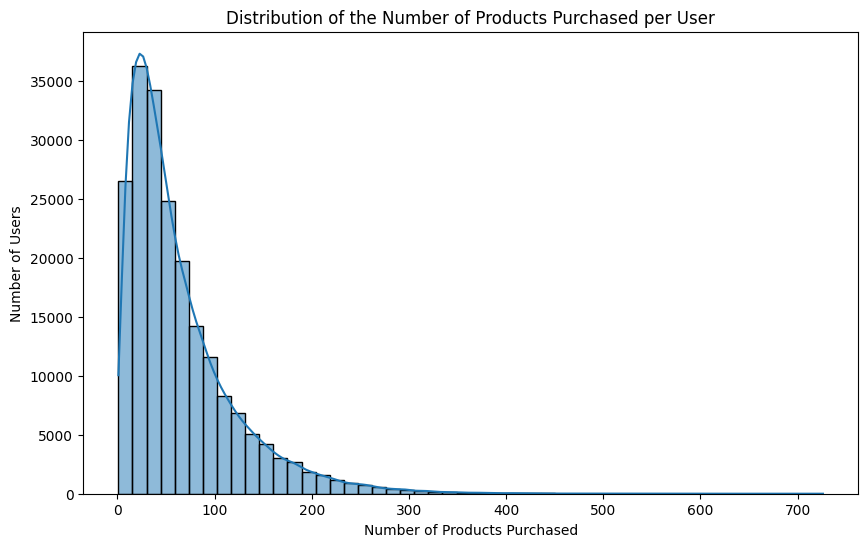

In [ ]:
# Plot distribution of the number of products purchased per user
user_order_counts = order_products.groupby('user_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(user_order_counts, bins=50, kde=True)
plt.title('Distribution of the Number of Products Purchased per User')
plt.xlabel('Number of Products Purchased')
plt.ylabel('Number of Users')
plt.show()

<ipython-input-13-7d249c04f7f4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_order_counts, y=product_order_counts.index, palette='viridis')


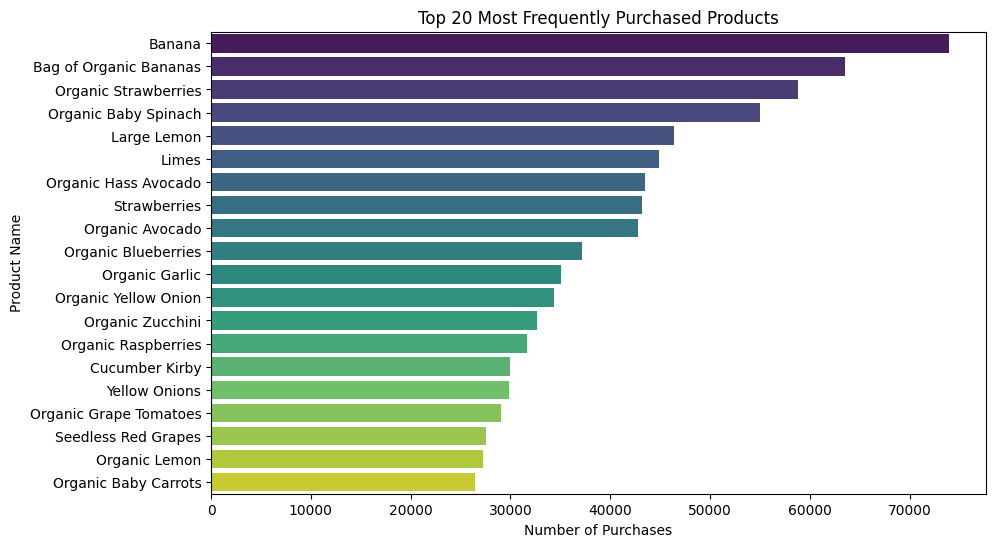

In [ ]:
# Plot top 20 most frequently purchased products
product_order_counts = order_products['product_name'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=product_order_counts, y=product_order_counts.index, palette='viridis')
plt.title('Top 20 Most Frequently Purchased Products')
plt.xlabel('Number of Purchases')
plt.ylabel('Product Name')
plt.show()

Create User-Item Matrix

In [ ]:
# Create User-Item Matrix
order_products['interaction'] = 1  # Create a column for interactions
user_item_matrix_sparse = csr_matrix((order_products['interaction'],
                                      (order_products['user_id'], order_products['product_id'])))

Apply TruncatedSVD for Dimensionality Reduction

In [ ]:
svd = TruncatedSVD(n_components=100, random_state=42)  # Reduced from 50 to 20 components
user_item_matrix_svd = svd.fit_transform(user_item_matrix_sparse)

In [ ]:
# Print explained variance ratio to see how much variance is captured
print(f"Explained Variance Ratio: {np.sum(svd.explained_variance_ratio_):.4f}")

Explained Variance Ratio: 0.1783


In [ ]:
# Check dimensions of user-item matrix and SVD output
print(user_item_matrix_sparse.shape)
print(user_item_matrix_svd.shape)

(206210, 49689)
(206210, 100)


Compute Similarity and Make Recommendations

In [ ]:
# Compute cosine similarity between items
item_similarity = cosine_similarity(user_item_matrix_svd.T)
# Create a DataFrame with reduced dimensions (50 components)
item_similarity_df = pd.DataFrame(item_similarity, index=range(item_similarity.shape[0]), columns=range(item_similarity.shape[1]))

In [ ]:
# Function to recommend products
def recommend_products(product_id, num_recommendations=5):
    if product_id not in item_similarity_df.columns:
        raise ValueError(f"Product ID {product_id} not found in similarity matrix.")

    similar_products = item_similarity_df[product_id].sort_values(ascending=False).index[1:num_recommendations+1]
    similar_product_names = products[products['product_id'].isin(similar_products)]['product_name']
    return similar_product_names

# Example: Recommend products similar to a specific product_id
recommended_products = recommend_products(1)
print("Recommended Products:")
print(recommended_products)

Recommended Products:
50    Sa Extra Hold Mousse Hair Styling
72    Jasmine Tea Unfiltered Ginger Ale
83                           Lamb Shank
88       Yogurt Fruit Dip Sliced Apples
89                         Smorz Cereal
Name: product_name, dtype: object
